By Prince Okoli — [GitHub](https://github.com/princyok/deep_learning_without_ml_libraries) — [Blog series](https://princyok.github.io/demonstration-of-the-models-in-action.html)

# Demonstration using Chest X-ray dataset

This is a dataset of chest x-ray images of patients suffering from pneumonia vs those that are not.

Important links:

* **Data source**: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

* Link to the original paper for the research that produced the dataset: https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

**This Jupyter notebook will put to the test the feedfoward neural network (multilayer perceptron) that was written from scratch without dependence on any ML libraries (see the blog series [*Catching AI with its pants down*](https://princyok.github.io/demonstration-of-the-models-in-action.html)).**  Machine learning libraries may be used in this notebook for cleaner and more efficient data preprocessing, but not for the actual learning.

### Cautionary note: Multilayer perceptrons are less suited for image classification!

A multilayer perceptron (a.k.a. a standard or vanilla feedforward neural network) is not the preferred architecture for image classification. That would be the family of convolutional neural networks because they take advantage of the spatial relations among the pixels of an image. 

For a multilayer perceptron (MLP), an input image is flattened to match the shape of its input layer. So already, we can expect an MLP to have considerable difficulty compared to better suited architectures in learning the mapping between an image and its label.

With this in mind, let's see the best we can achieve.

# Learning goal

The goal for the MLP is to learn the correct mapping between an image and the correct label of that image.

Each pixel of an image is treated as a feature (an input variable). For instance, a 100 x 100 image will be represented as datapoint of 10,000 features. MLP has to learn the correct mapping between this vector of length 10,000 (that represents the image) to the correct label (0 for pneumonia and 1 for normal).

# Set working directory

Ensure that the current working directory is set to the top-level directory of the project. <font color=red>Change this as needed<font>.

In [1]:
import os
CWD = os.path.expanduser("~/OneDrive/Research Projects/deep_learning_without_ml_libraries")
os.chdir(CWD)

# Input pipeline

An input pipeline handles all the preprocessing for our data before feeding them to our neural net. We use the [TensorFlow Dataset API](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) because it allows us to perform all the preprocessing of the data batchwise, instead of on the entire dataset at once. This way we don't get the dreaded [MemoryError](https://docs.python.org/3/library/exceptions.html#MemoryError), or even worse, crash our computer.

In [2]:
# Import all needed libraries.

from matplotlib import pyplot
import tensorflow as tf
import multilayer_perceptron as nn
import numpy as np
import os

### Load images

The dataset has 3 top-level directories named `train`, `test` and `val`: 

* The `train` directory contains 1341 normal and 3875 pneumonia chest x-ray images. 

* The `test` directory has 234 normal and 390 pneumonia chest x-ray images. 

* The `val` directory has 8 normal and 8 pneumonia chest x-ray images. In total, there are 1583‬ normal images and 4273 pneumonia images in this dataset.

We will load all the images from the `train` and `test` directories, and split them later into training and validations sets using our own preferred split ratio. We will use the `val` directory, which has only 16 images, as our test set.

In [3]:
# Load the file paths for all the images.

# We will ignore the original train-test split provided in the dataset and use ours later.

filepaths_normal = tf.data.Dataset.list_files(["datasets/chest-xray-pneumonia/test/NORMAL/*",
                                               "datasets/chest-xray-pneumonia/train/NORMAL/*"], shuffle=False)

filepaths_pneumonia = tf.data.Dataset.list_files(["datasets/chest-xray-pneumonia/test/PNEUMONIA/*",
                                               "datasets/chest-xray-pneumonia/train/PNEUMONIA/*"], shuffle=False)

In [4]:
# Let's check out some of what we loaded.

for elem in filepaths_normal.take(3):
    print(elem)

tf.Tensor(b'datasets\\chest-xray-pneumonia\\test\\NORMAL\\IM-0001-0001.jpeg', shape=(), dtype=string)
tf.Tensor(b'datasets\\chest-xray-pneumonia\\test\\NORMAL\\IM-0003-0001.jpeg', shape=(), dtype=string)
tf.Tensor(b'datasets\\chest-xray-pneumonia\\test\\NORMAL\\IM-0005-0001.jpeg', shape=(), dtype=string)


### Build input pipeline

We define a function, `input_pipeline`, that will handle all preprocessing needed for the images. We also define three supporting functions that `input_pipeline` will use. 

The supporting function `get_label` will:
* Assign a label of `1` to all images contained in the directory `NORMAL`, and `0` to all images under the directory `PNEUMONIA`.

The supporting function `get_and_process_img` will:

* Load images into memory as [Tensor](https://www.tensorflow.org/api_docs/python/tf/Tensor) objects, which will hold each image as a 3-dimensional array with the shape (`height`, `width`, `num_color_channel`). Being monochromatic images, the number of color channels (`num_color_channel`) will be 1.

* Scale their color intensities from the standard range of 0 to 255 to a new range of 0 to 1

* Resize the image to a smaller size, so that when flattened doesn't produce a ginormous vector.

The supporting function `flatten_img` will:

* Flatten each tensor to a shape of (`1`, `n`), where `n` = `height` x `width` x `num_color_channel`.

In [5]:
def get_label(file_path):
    
    # Break up the filepath to a list of component directories
    parts = tf.strings.split(file_path, os.path.sep)
    
    # The name of the second to last directory is the class.
    if parts[-2] == tf.constant("PNEUMONIA"):
        label = tf.constant(0)
    else:
        label = tf.constant(1)
    label = tf.reshape(label, [tf.math.reduce_prod(tf.shape(label))])
    
    return label

In [6]:
def get_and_process_img(file_path):
    
    img = tf.io.read_file(file_path)
    
    # Note: img is a Tensor object whose elements are of type String.
    # Convert img to a Tensor of type uint8.
    img = tf.image.decode_jpeg(img, channels=1)
    
    # Scale img to range of 0 to 1.
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # resize the img to the desired size.
    img = tf.image.resize(img, [500, 500])
    
    return img

In [7]:
def flatten_img(img):
    #flatten the img Tensor.
    new_img_tensor_shape = [tf.math.reduce_prod(tf.shape(img))]    
    img = tf.reshape(img, new_img_tensor_shape)
    return img

In [8]:
def input_pipeline(file_path):
    label = get_label(file_path)    
    img = get_and_process_img(file_path)
    img = flatten_img(img)
    return img, label

### Spot-check the data

Check out a few of the images.

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


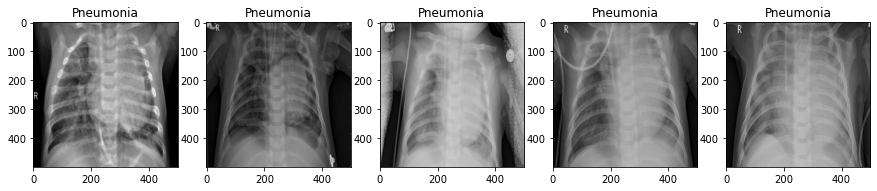

In [9]:
# Pneumonia images.

num_img_plot=5

fig, axes = pyplot.subplots(1, num_img_plot, figsize=(15,15))

for i, img in filepaths_pneumonia.map(get_and_process_img).enumerate().take(num_img_plot):
    axes[i].imshow(tf.squeeze(img, axis=2), cmap="gray")
    axes[i].set_title("Pneumonia")
fig.show()


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


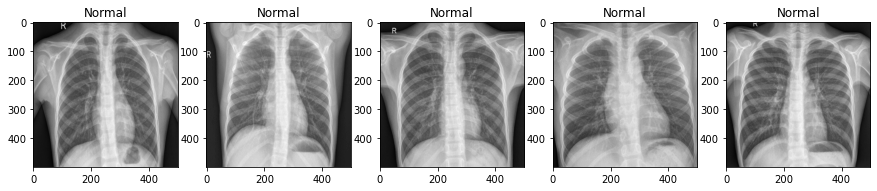

In [10]:
# Normal images.

num_img_plot=5

fig, axes = pyplot.subplots(1, num_img_plot, figsize=(15,15))

for i, img in filepaths_normal.map(get_and_process_img).enumerate().take(num_img_plot):
    axes[i].imshow(tf.squeeze(img, axis=2), cmap="gray")
    axes[i].set_title("Normal")
fig.show()

### Balance the class distribution

Specify the total number of images to use for each class in order to ensure a balanced dataset. A balance dataset is needed because I didn't allow for class weights in the code implementation of the cost function (this is another room for improvement). 

There are 1584 normal images and 4265 pneumonia images. We will undersample pneumonia images to achieve balance. 

Do note that due to the random nature of batching, some batches will have a slight imbalance (e.g. one class making up to 60% of the batch), but nothing too far from a 50-50 split of classes, and on average the split will be 50-50.

In [11]:
seed = 3 # seed to ensure deterministic shuffling.

num_per_class=1500

# Note that we shuffle the file paths (once and deterministically) instead of 
# the images. This reduces the load on memory.

buffer_size=3000

filepaths_pneumonia = filepaths_pneumonia.shuffle(buffer_size, seed=seed, reshuffle_each_iteration=False)\
    .take(num_per_class)

filepaths_normal = filepaths_normal.shuffle(buffer_size,seed=seed, reshuffle_each_iteration=False)\
    .take(num_per_class)


In [12]:
# Combine the two classes together into a single dataset, again shuffling deterministically.

filepaths_data=tf.data.experimental.sample_from_datasets([filepaths_pneumonia, filepaths_normal], seed=seed)

### Split data

Split the data into training and validation sets. We use a validation set to assess generalization after each iteration of training. 

The difference between validation and test sets is simply a naming convention to distinguish between assessing generalization while training (in which case, a validation set) versus after training (a test set). Both cases refer to data that the model never learns from and are used only for assessment.

In [13]:
total_data_size=num_per_class * 2

split_ratio = 0.9 # 0.9 means 90% of data is used as the training set.

train_size = round(split_ratio * total_data_size) 
validat_size = total_data_size - train_size

filepaths_train=filepaths_data.take(train_size)
data_train =filepaths_train.map(input_pipeline)

filepaths_validat=filepaths_data.skip(train_size).take(validat_size)
data_validat=filepaths_validat.map(input_pipeline)

In [14]:
count0=count1=0

for img, label in data_validat.take(validat_size).as_numpy_iterator():
    if label.squeeze()==0:
        count0+=1
    else:
        count1+=1

print("Number of Pneumonia and Normal images in validation set are: {}, {}".format(count0, count1))

Number of Pneumonia and Normal images in validation set are: 160, 140


### Flattened image vs unflattened (regular)

Let's see how an image looks before and after flattening

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


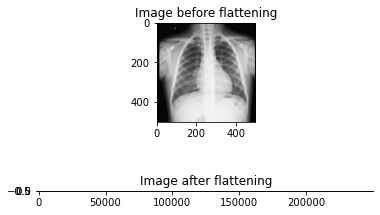

In [15]:
# How a single image looks before and after flattening. 

fig, axes = pyplot.subplots(2, 1)
for img, label in data_train.take(1).as_numpy_iterator():
    axes[0].imshow(img.reshape(500, 500), cmap="gray")
    axes[0].set_title("Image before flattening")
    axes[1].imshow(img.reshape(1,-1))
    axes[1].set_title("Image after flattening")
fig.show()

After flattening, an image is now just one very thin strip that is just one pixel thick; in this case, 1 by 250,000.

As mentioned earlier, this is one of the key weaknesses of using MLP for image classification.

Let's verify the shape of a batch to ensure it's what we expect. For images, we expect (`batch_size`, `250000`)

In [16]:
# Extract a portion of the dataset.

sample_size=10

for i, batch in data_train.batch(sample_size).enumerate().as_numpy_iterator():
    if i==0:
        print("Shape of a batch of {} images: {}".format(sample_size, batch[0].shape))
        print("Shape of a batch of {} labels: {}".format(sample_size, batch[1].shape))
            
    else:
        break

Shape of a batch of 10 images: (10, 250000)
Shape of a batch of 10 labels: (10, 1)


### Extract the validation set

We don't want to repetitively extract the validation set for every iteration of training, especially since it's the same batch of validation set that is used for every iteration.

In [17]:
# Extract the validation set.

for validation_set in data_validat.batch(validat_size).as_numpy_iterator():
    x_validat=validation_set[0].T
    y_validat=validation_set[1].T

# Learning

With data preparation complete, we are ready to begin training an MLP to learn from the dataset.

### Set up the neural network

Set up the MLP network. We already imported the custom module, `multilayer_perceptron`, as `nn`. Feel free to look through the module and see what's under the hood. Also, exhaustive explanation on how it was written is the focus of my blog series [*Catching AI with its pants down*](https://princyok.github.io/some-musings-about-ai.html).

We will use 5 hidden relu layers and an output logistic (sigmoid) layer. We use a sigmoid output layer because this is a classification task.

In [18]:
from multilayer_perceptron import network

nn.layer

<module 'multilayer_perceptron.layer' from 'C:\\Users\\prince.okoli\\OneDrive\\Research Projects\\deep_learning_without_ml_libraries\\multilayer_perceptron\\layer.py'>

In [19]:
# Instantiate 6 layers (5 hidden and 1 output).
l1=nn.layer.Layer("relu", 256) 
l2=nn.layer.Layer("relu", 384) # 384 units (artificial neurons).                       
l3=nn.layer.Layer("relu", 512) 
l4=nn.layer.Layer("relu", 768) # 768 units (artificial neurons).                     
l5=nn.layer.Layer("relu", 1024)
l6=nn.layer.Layer("logistic", 1)


layers=[l1, l2, l3, l4, l5, l6]

# Instantiate the network.
network=nn.network.MLPNetwork()

# Add the layers to the network and initialize the parameters.
network.add_layers(layers)
network.initialize_parameters(factor=0.01, weight_init_scheme="xavier")

Set up how data generated during training is cached and what gets displayed.

In [20]:
archiver=nn.archiver.TrainingArchiver()

# Cache cost, accuracy and precision every 10 iterations.
archiver.set_archiving_frequencies(cost=10, accuracy=10, precision=10)

# Display cost and accuracy during each caching event.
archiver.set_archiving_verbosities(cost=False, accuracy=False, precision=False)

# add the archiver to the network.
network.add_training_archiver(archiver)
# Can also be re-accessed via network.training_archiver

### Training

We have three hyperparameters to control: batch size, number of epochs, and learning rate.

#### Number of epochs

An epoch is one complete cycle through the entire training set. Passing the entire dataset once through the network during training marks the completion of one epoch.

The number of epochs controls how long we train for. It requires multiple iterations of training to complete one epoch (see section on batch size below for more).

#### Batch size

We choose a batch size that won't blow our memory (you can go bigger depending on the size of your RAM). 

The batch size also determines the number of training iterations per epoch. So, if the size of our training set is 2700 records, and our batch size is 270, then there would be 10 iterations of training in one epoch, because there would need to be 10 iterations of training for the neural net to see all the data in the training set.

#### Learning rate

We will go with a reasonably small learning rate so that we can have a smoother decline of the cost, at least initially (and also because I know we are dealing with relu layers here, and therefore could face severe dying relu). But to make up for the slower rate of learning, we will go with a high number of epochs (and consequently high number of iterations), which means training will take more than a few minutes (expect a few hours). 

A higher learning rate will reduce how long we have to train but will also increase the variation in the cost across iterations (i.e. a very noisy-looking plot of cost vs. iterations), and if the learning rate is too high the optimization (training) can simply fail for a number of reasons, one of them being due to the dying relu phenomenon!

#### An alternative approach: Train forever!

An alternative approach will be to training indefinitely by setting the number of epochs to infinity, and then condition the training to stop after a specified threshold in performance metrics (e.g. cost, accuracy, etc.) has been crossed. For example, we could set the network to train until validation cost drops below a specified threshold, or validation accuracy rises above a specified threshold. This requires us to be confident that the specified threshold is attainable.

In [21]:
num_epochs=150
batch_size=150
learning_rate=0.0001

In [22]:
# train the network.
for batch in data_train.batch(batch_size).repeat(num_epochs).as_numpy_iterator():
    
    network.train(X=batch[0].T, Y=batch[1].T, num_iterations=1, batch_size=None, learning_rate=learning_rate, 
                  print_start_end=False, validation_X=x_validat, validation_Y=y_validat)
    
# The print-out is very long. Also, you can change that with archiver.set_archiving_frequencies.

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Evaluation after training

Let's check out the metrics that we specified to be cached; namely, `cost`, `precision`, and `accuracy`.

In [23]:
def plot_metric(metric_name, all_iterations, all_training_metric, all_validat_metric=None, learning_rate=None):
    
    x_plot=all_iterations

    fig, ax = pyplot.subplots(1, 1)
    
    if learning_rate == None:
        learning_rate=""
    
    if all_training_metric != None:
        ax.plot(x_plot,all_training_metric, label="training")
    if all_validat_metric != None:
        ax.plot(x_plot,all_validat_metric, label="validation")

    ax.set_ylabel(metric_name)
    ax.set_xlabel('Num of iterations')
    ax.set_title("Learning rate =" + str(learning_rate))
    ax.legend()
    fig.show()

In [24]:
# Get the training archiver that holds archives of all data it was instructed to cache during training.

archiver = network.training_archiver

## Cost

In the plot below, we can observe that both validation and training cost are still in a downtrend, although the rate of decline is slowing. This suggests that training a bit longer may still likely improve performance.

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


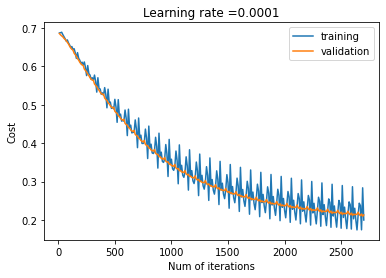

In [25]:
# plotting the training and validation costs.

all_iterations=list(archiver.all_training_costs.keys())

all_training_cost=list(archiver.all_training_costs.values())
all_validat_cost=list(archiver.all_validation_costs.values())
        

plot_metric("Cost", all_iterations, all_training_cost, all_validat_cost, learning_rate)

## Accuracy

In the plot below, we can observe that both validation and training cost are still in slight uptrend, although the rate of increase has slowed considerably. 

This still suggests that training a bit longer can likely squeeze in a little more improvement in performance, although we face the danger of considerably overfitting (a situation were the performance metrics for the training set continue to improve as that of the validation set plateaus or begin to decline).

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


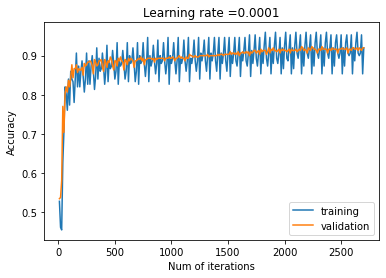

In [26]:
# plot the training and validation accuracies.

all_iterations = list(archiver.all_training_accuracies.keys())

all_training_accur = list(archiver.all_training_accuracies.values())
all_validat_accur = list(archiver.all_validation_accuracies.values())

plot_metric("Accuracy", all_iterations, all_training_accur, all_validat_accur, learning_rate)

### Precision

Precision tells us how precise the predictions for class 1 (the positive class) are. It is the proportion of the predictions of positive (i.e. class 1 or "normal") that are actually correct.

We want high accuracy and high precision. We also want high sensitivity and specificity, but I didn't implement those.

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


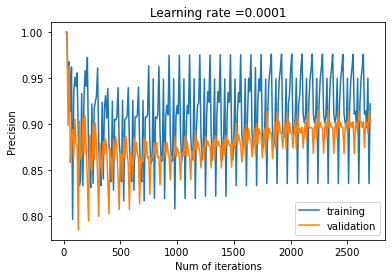

In [27]:
# plotting the training and validation precisions.

all_iterations=list(archiver.all_training_costs.keys())

all_training_prec=list(archiver.all_training_precisions.values())
all_validat_prec=list(archiver.all_validation_precisions.values())
        

plot_metric("Precision", all_iterations, all_training_prec, all_validat_prec, learning_rate)

## Spot-check the training result

Let's check out a few of the predictions for the validation set.

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


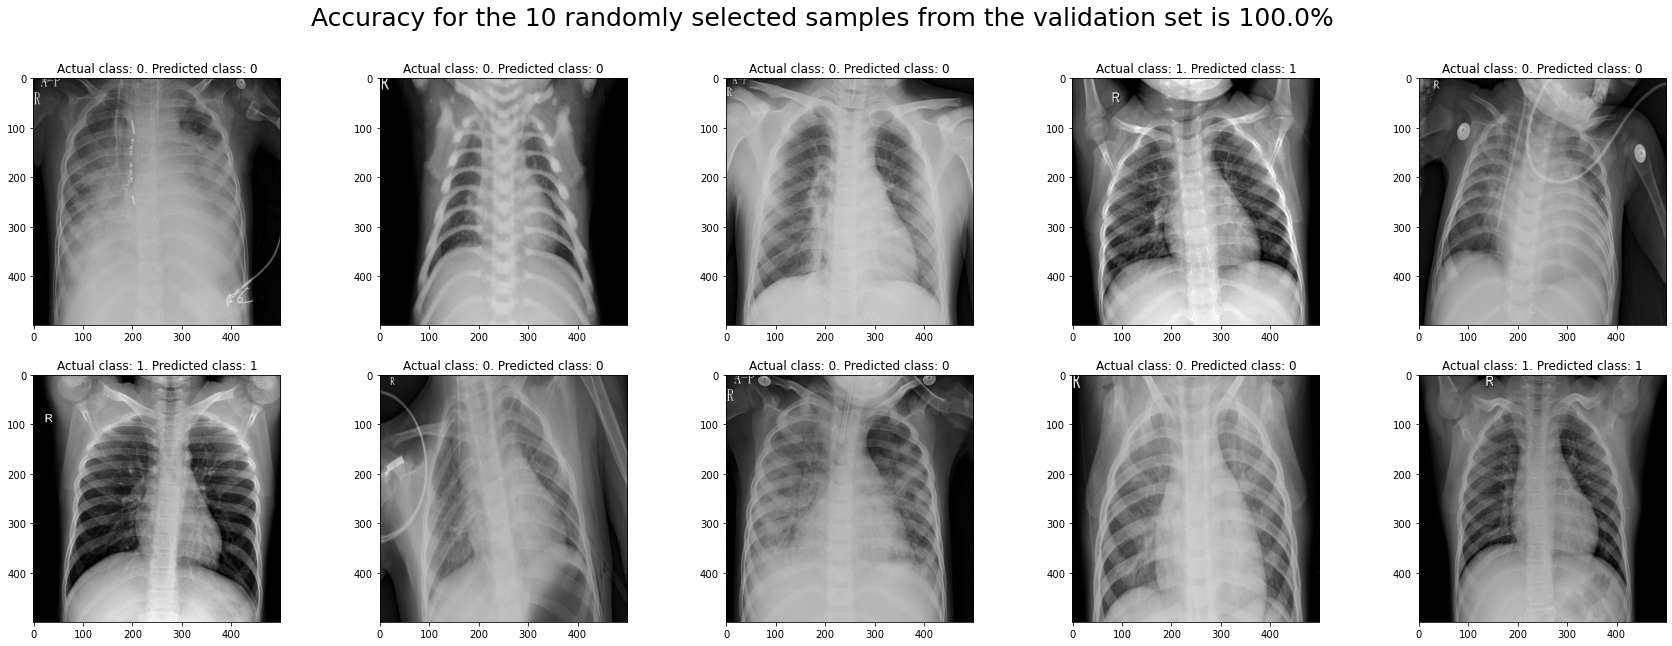

In [28]:
# Check predictions for images randomly selected from the validation set.

prng=np.random.RandomState(seed=33)

num_img_plot=10

rows_of_plot = 2

# Generate random indices.

random_indices = prng.choice(validat_size, num_img_plot, replace=False)

# Select random images, both the flattened and nonflattened forms.

images_flat = x_validat[:, random_indices]
images_nonflat = images_flat.T.reshape(-1, 500, 500)

actual_labels = y_validat[:, random_indices]
predicted_labels = network.predict(images_flat)

fig_title="Accuracy for the {} randomly selected samples from the validation set is {}%"\
    .format(num_img_plot, 100*network.evaluate(images_flat, actual_labels))

fig, axes = pyplot.subplots(rows_of_plot, (num_img_plot+rows_of_plot-1)//rows_of_plot, figsize=(30, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images_nonflat[i,:,:], cmap="gray")
    ax.set_title("Actual class: {}. Predicted class: {}".format(actual_labels[0, i], predicted_labels[0, i]))
fig.suptitle(fig_title, fontsize=25)
fig.show()

## Evaluate the trained network on the test set

Test set accuracy: 93.75%
Test set precision: 100.00%


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


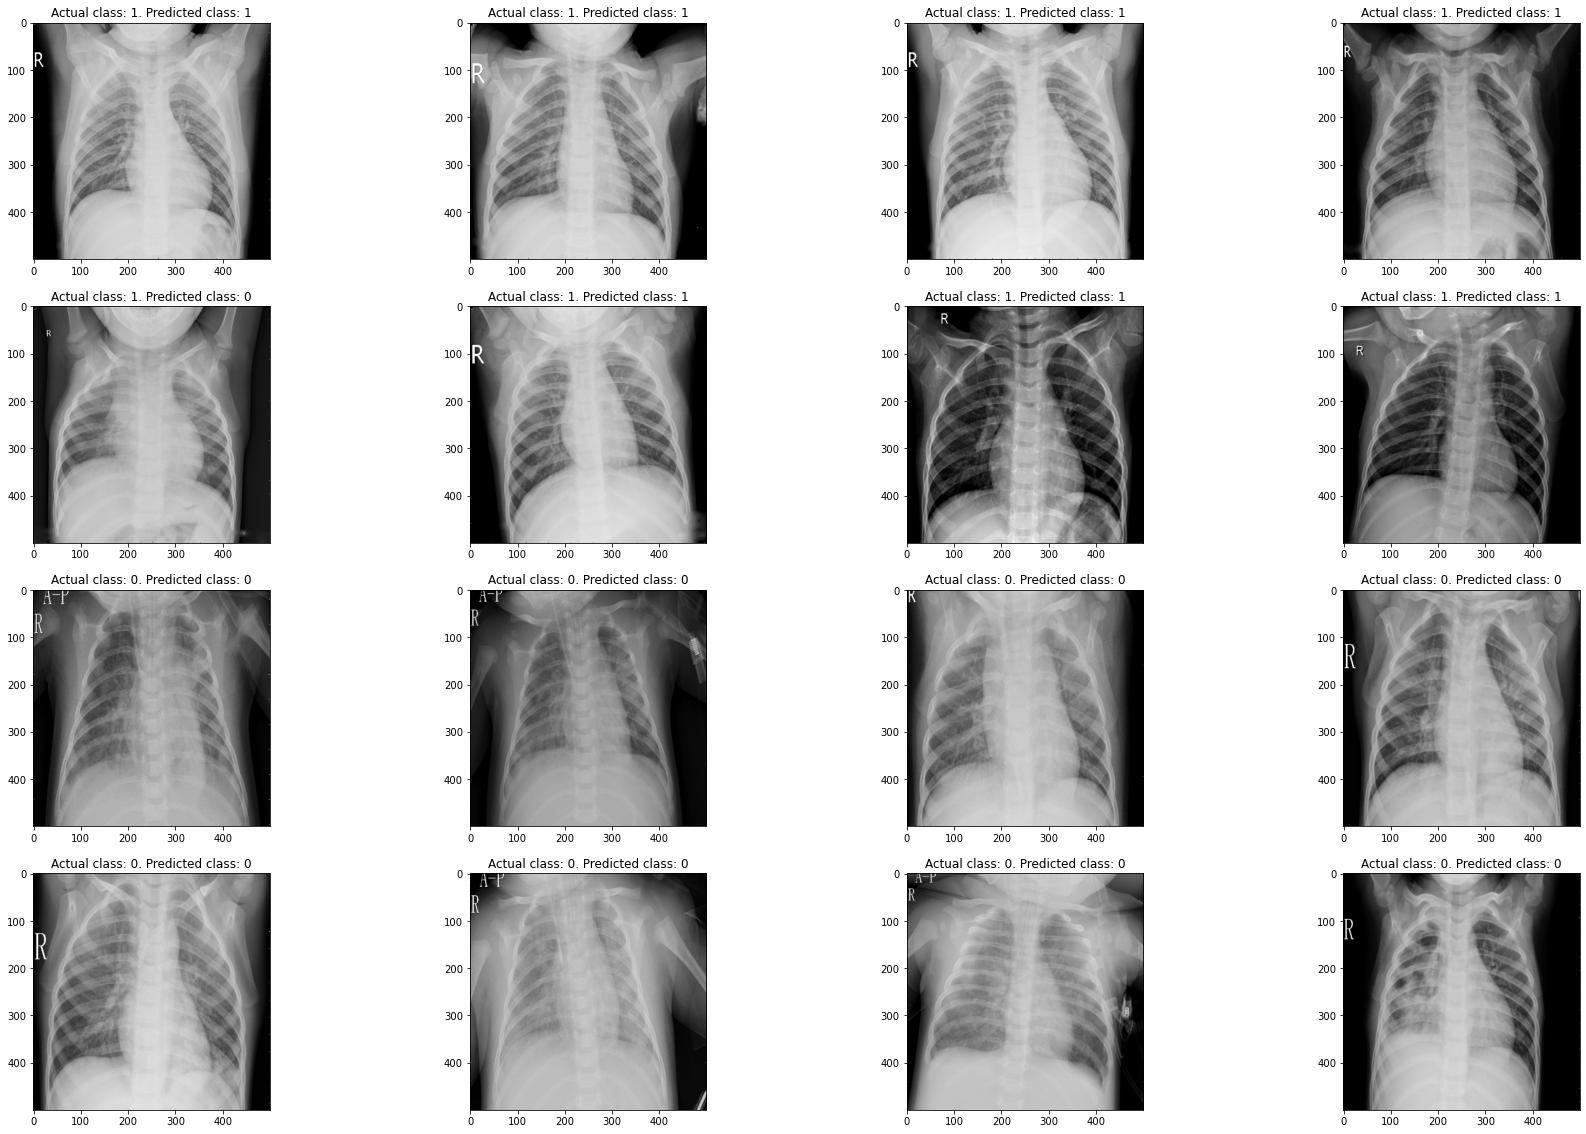

In [29]:
num_img_plot=16

rows_of_plot = 4

filepaths_test = tf.data.Dataset.list_files(["datasets/chest-xray-pneumonia/val/*/*"], shuffle=False)


data_test_nonflat=filepaths_test.map(get_and_process_img).batch(16).as_numpy_iterator()
data_test=filepaths_test.map(input_pipeline).batch(16).as_numpy_iterator()

for test_nonflat in data_test_nonflat:
    x_test_nonflat = np.squeeze(test_nonflat, axis=3)
    
for test in data_test:
    x_test=test[0].T
    y_test=test[1].T
    

predicted_labels = network.predict(x_test)

print("Test set accuracy: {0:.2f}%".format(100*network.evaluate(x_test, y_test, metric="accuracy")))
print("Test set precision: {0:.2f}%".format(100*network.evaluate(x_test, y_test, metric="precision")))

fig, axes = pyplot.subplots(rows_of_plot, (num_img_plot+rows_of_plot-1)//rows_of_plot, figsize=(30, 20))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_test_nonflat[i,:], cmap="gray")
    ax.set_title("Actual class: {}. Predicted class: {}".format(y_test[0, i], predicted_labels[0, i]))
fig.show()


## Summary of results

Let's find out the exact accuracy and precision on the validation set for the last state of the neural network:

In [30]:
print("Validation set accuracy: {0:.2f}%".format(100*network.evaluate(x_validat, y_validat)))
print("Validation set precision: {0:.2f}%".format(100*network.evaluate(x_validat, y_validat, metric="precision")))

Validation set accuracy: 92.00%
Validation set precision: 90.28%


We achieved **accuracy and precision of 92% and 90% on the validation set**, and could have probably squeezed out a few more percentages on both by training for longer. Also, we didn't really do any hyperparameter tuning (I tested out two other learning rates before settling for 0.0001).

For the test set, we achieved **93.75% accuracy (15 correct predictions out of 16) and 100% precision.**

## Save the trained model

We can save the entire network using `pickle`. All the data types in the network are either native python types or numpy types, both of which `pickle` can serialize without hassle. Alternatively, you can extract just the trained (optimized) parameters and other data generated via training and save only those.

Later, you can load the saved network instead of training a fresh one all over again.

In [31]:
import pickle

def save_data(data, filepath):
    with open(filepath, 'wb') as file:
        # Pickle all_parameters using the highest protocol available.
        pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)
    return None
    
def load_saved_data(filepath):
    with open(filepath, 'rb') as file:  
        data=pickle.load(file) 
    return data

In [33]:
# Note that this could be a few 100 MB to a few GB, depending on how many parameters the network was given.

save_data(network, filepath= "neural_network_demonstration/saved_models/chest_xray_pneumonia_network.pickle")

To load a saved network, uncomment and run the cell below:

In [34]:
# network=load_saved_data(filepath= "saved_models/chest_xray_pneumonia_network.pickle")

To save only parameters (weights and biases), you can use or adapted this code block:

````
all_weights=dict()
all_biases=dict()

for i in range(1,len(layers)):
    l=i+1
    all_weights[l]=network.layers[l].W
    all_biases[l]=network.layers[l].B
all_parameters={"W":all_weights, "B":all_biases}
    
save_data(all_parameters, filepath= "saved parameters/chest_xray_pneumonia_parameters")
````

To load back the saved parameters, you use this code block:

````
filepath="saved parameters/chest_xray_pneumonia_parameters"

with open(filepath+".pickle", 'rb') as file:  
    all_parameters=pickle.load(file)

for i in range(0,len(all_parameters["W"])):
    l=i+1
    network.layers[l].W=all_parameters["W"][l]

for i in range(0,len(all_parameters["B"])):
    l=i+1
    network.layers[l].B=all_parameters["B"][l]
````

To save only the cached perfomance metrics, you can use this code block:

````
saved_perfomance_data={"training_cost":archiver.all_training_costs, 
                       "validation_cost":archiver.all_validation_costs,
                     "training_precision":archiver.all_training_precisions,
                     "validation_precision":archiver.all_validation_precisions,
                     "training_accuracy":archiver.all_training_accuracies,
                     "validation_accuracy":archiver.all_validation_accuracies}

save_data(saved_perfomance_data, filepath= "saved parameters/chest_xray_pneumonia_performance")
````

# Look under the hood

### Plot activations

Let's visualize how an image is transformed as it passes from input layer to output layer.

Folding the flattened image back to its original structure is straightforward. We simply reshape the image from (1, 250000) back to (500, 500) (or (500, 500, 1)). But folding the hidden layers of a multilayer perceptron into an image is not well defined. We have a carte blanche on how to fold the hidden layer. We will choose arbitrary image sizes to fold the hidden layers into. 

What's important to keep in mind is that for each input image, we are representing each unit (neuron) of the hidden layers as a pixel, regardless of how we choose to fold that vector of activations. We should not expect the visual representation for the hidden layers to produce some meaningful images that we can recognize. It is simply a plot of activations, no more! It is just a visualization of how activations are transformed from input to output layer.

The activation values for the input layer (the input image) range from 0 to 1 (because we scaled the color intensity as part of the input pipeline). The activation values in the hidden layers can range from 0 to positive infinity because of the [ReLU activation function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) used. The activation values of the output layer range from 0 to 1 because of the logistic (sigmoid) activation function used.

We will fold the layers for each input image accordingly:

* Input Layer (Layer 0): Reshaped from `(250000, 1)` to `(500, 500)`. This reverses the flattening operation carried out on the images.
* Layer 1: Reshape from `(256, 1)` to `(16, 16)`.
* Layer 2: Reshape from `(384, 1)` to `(24, 16)`.
* Layer 3: Reshape from `(512, 1)` to `(32, 16)`.
* Layer 4: Reshape from `(768, 1)` to `(48, 16)`.
* Layer 5: Reshape from `(1024, 1)` to `(64, 16)`.
* Output Layer: Shape stays same, `(1,1)`.

We will be using the last state of the network:

In [35]:
print("That is the state at the end of the {}th iteration".format(network.num_latest_iteration))

That is the state at the end of the 2700th iteration


Plot some examples from class "Pneumonia" that were also correctly predicted as "Pneumonia":

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


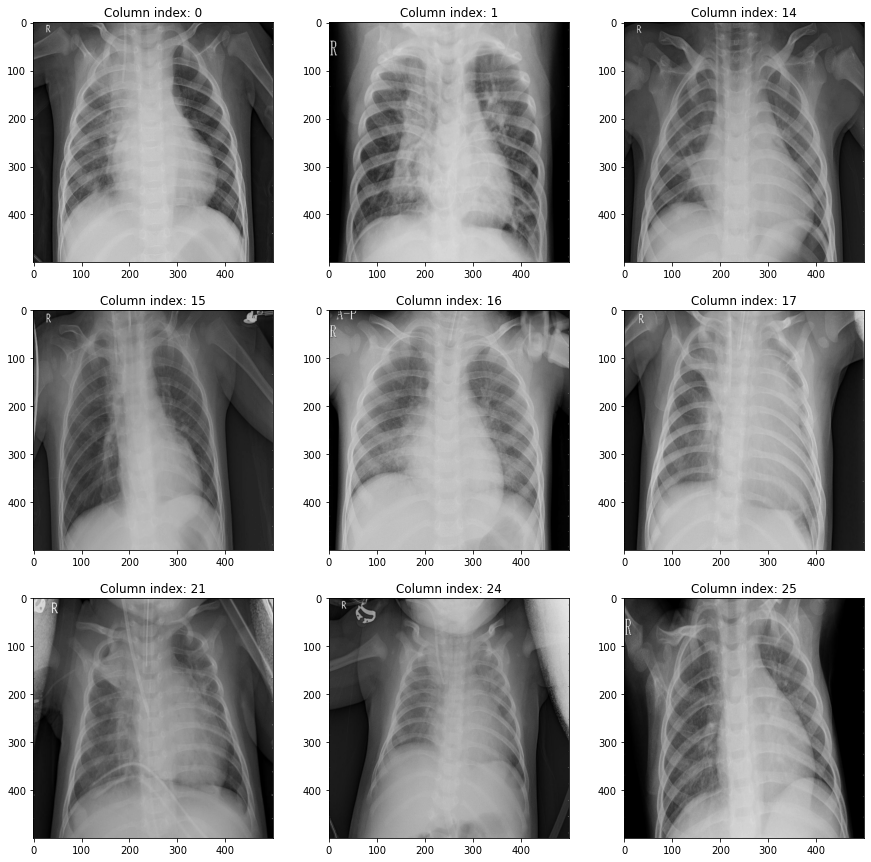

In [36]:
# Indices of all records labelled as class 0 (pneumonia) and also correctly predicted.

label0_indices=np.where((network.Y_batch == 0) & (network.Y_batch == network.Y_pred))

# Plot the first 9 in a 3-by-3 grid of subplots.

fig, axes = pyplot.subplots(3, 3, figsize=(15,15))

label0_col_idx=label0_indices[1]

for i, ax in enumerate(axes.flat):
    col_idx_img=label0_col_idx[i]
    ax.imshow(network.input_layer.A[:,col_idx_img].reshape(500,500), cmap="gray")
    ax.set_title("Column index: "+str(col_idx_img))
fig.show()


Plot some examples from class "Normal" that were also correctly predicted as "Normal":

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


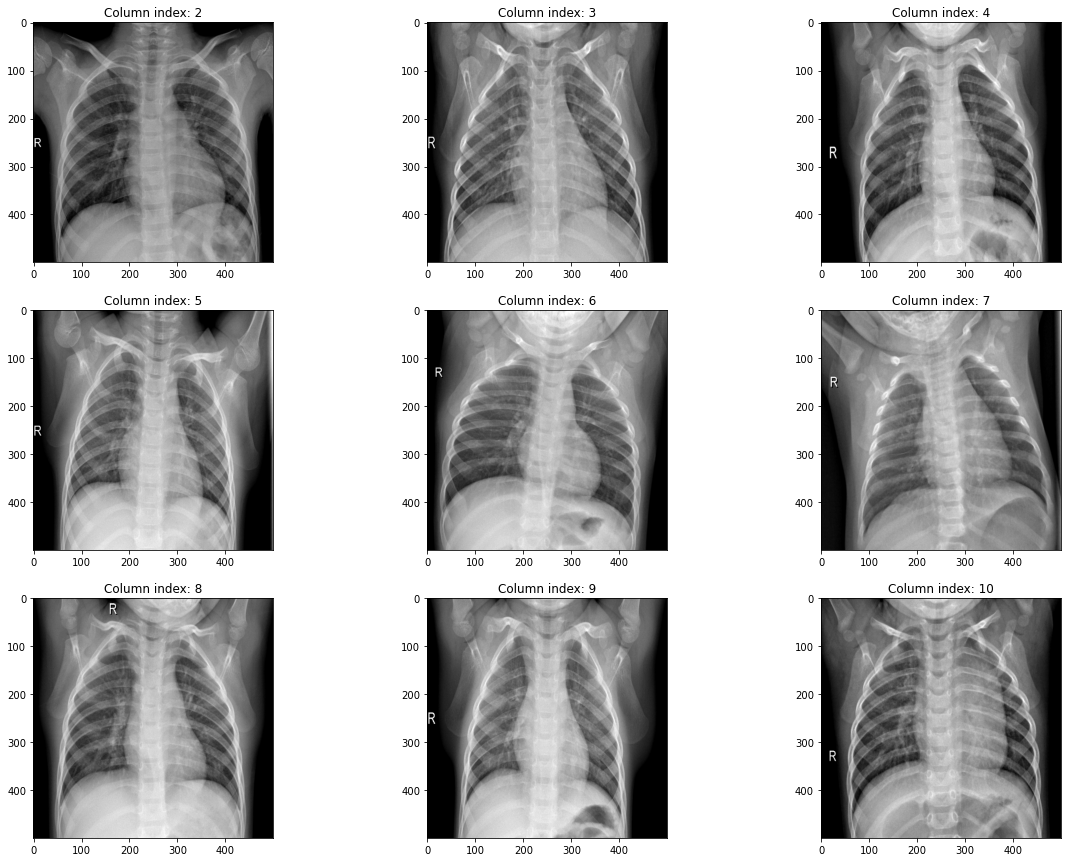

In [37]:
# Indices of all records labelled as class 1 (normal) and also correctly predicted.

label1_indices=np.where((network.Y_batch == 1) & (network.Y_batch == network.Y_pred))

label1_col_idx=label1_indices[1]

# Plot the first 9 in a 3-by-3 grid of subplots.

fig, axes = pyplot.subplots(3, 3, figsize=(20,15))

for i, ax in enumerate(axes.flat):
    col_idx_img=label1_col_idx[i]
    ax.imshow(network.input_layer.A[:,col_idx_img].reshape(500,500), cmap="gray")
    ax.set_title("Column index: "+str(col_idx_img))
fig.show()

I'm no radiologist, so I can't comment much on the images. But I can check to see how the patterns of activations vary for samples from different classes. 

Let's pick `0`, `1`, `14` for pneumonia, and `8`, `9` and `10` for normal.

In [38]:
def plot_network_activations(network, indices_to_plot, reshape_mapping):
    
    for record_index in indices_to_plot:
        
        fig, axes = pyplot.subplots(1, len(network.layers), figsize=(20, 60))

        for l, ax in enumerate(axes.flat):
            activations=network.layers[l].A[:,record_index].reshape(reshape_mapping[l])

            if l==0:
                # For input layer.
                
                ax.imshow(activations, cmap="gray")
            
            elif l < (len(network.layers)-1):
                # For Hidden layers.

                ax.imshow(activations, cmap="magma")
            else: 
                # For the output layer.
                # Set the range of the colormap to: 0 to 1.
                ax.imshow(activations, cmap="magma", vmin=0, vmax=1)
                ax.text(0,0, str((100*activations.squeeze()).round(1))+"%", fontsize=15,
                         ha='center',va='center', color="magenta")

            ax.set_title("Layer {}".format(l))
        
        fig.show()

Plot the activations generated in each layer for the selected records (examples). The activation of the output layer (Layer 6), which represents the probability of belonging to class 1 (class "Normal"), is converted to percentage. 

The cutoff threshold for the classes is 50%. An example is predicted as class 0 if the the output layer activation is 50% or lower, and class 1 if above 50%. Note that, as mentioned earlier, only correctly predicted examples are plotted below.

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


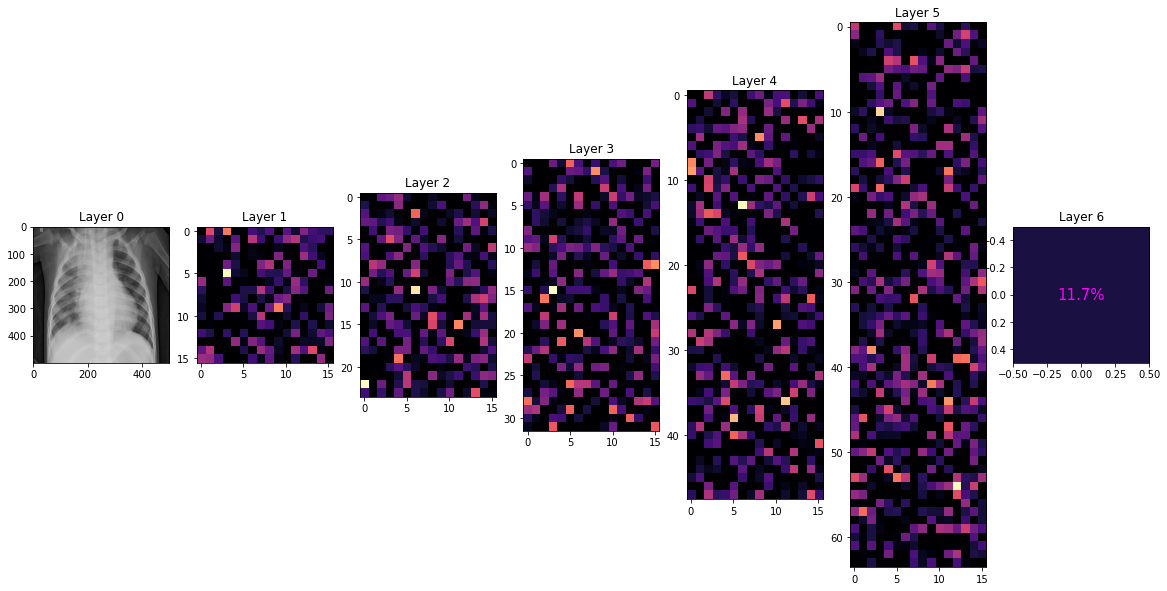

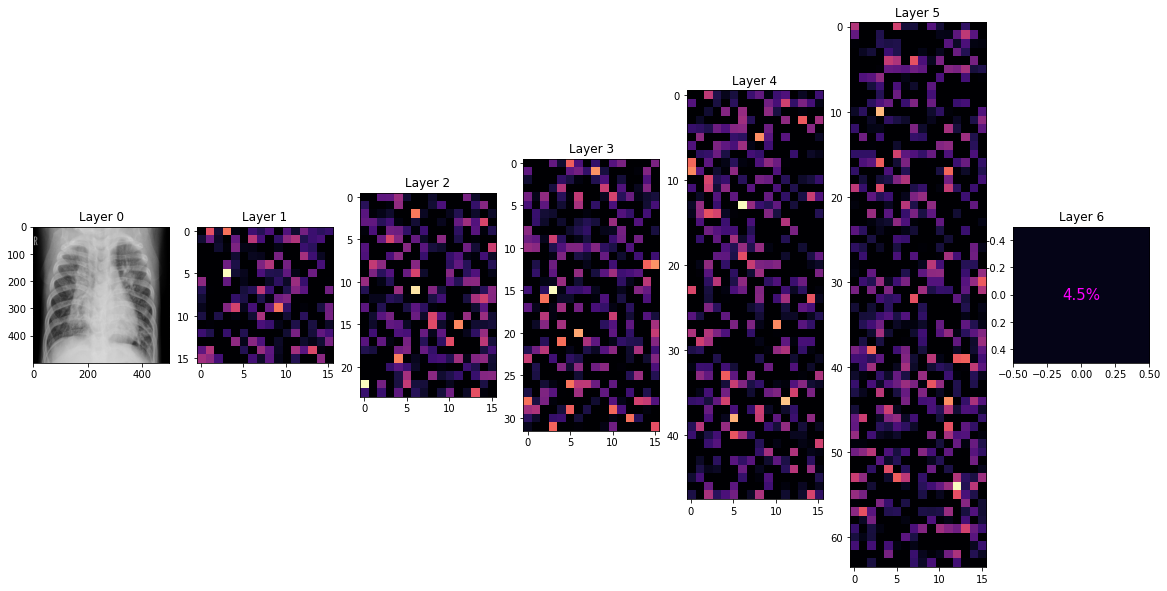

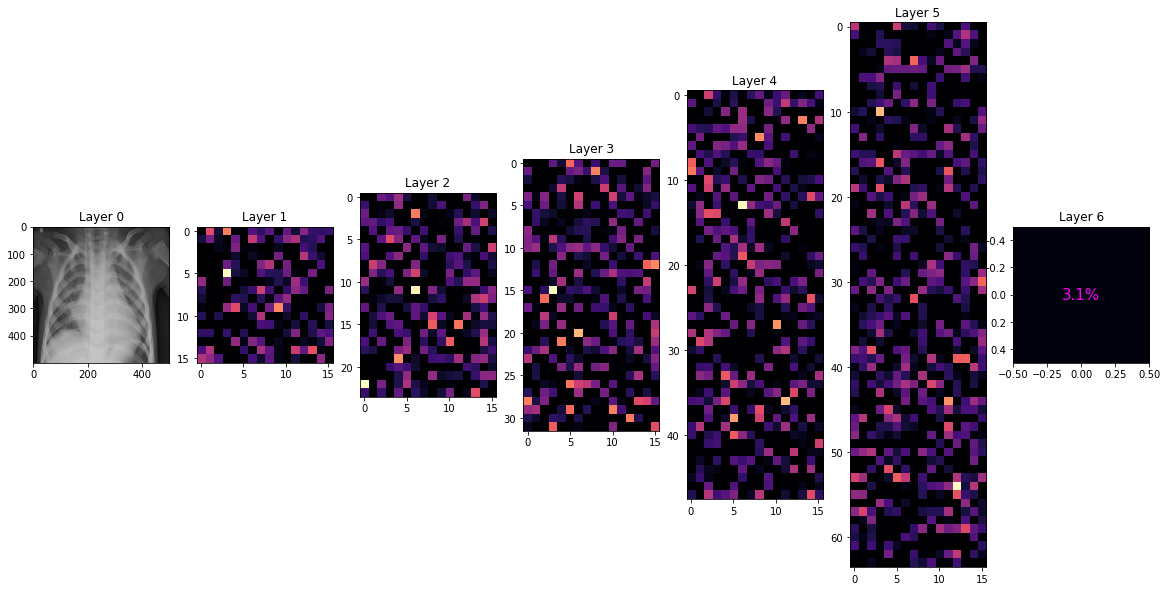

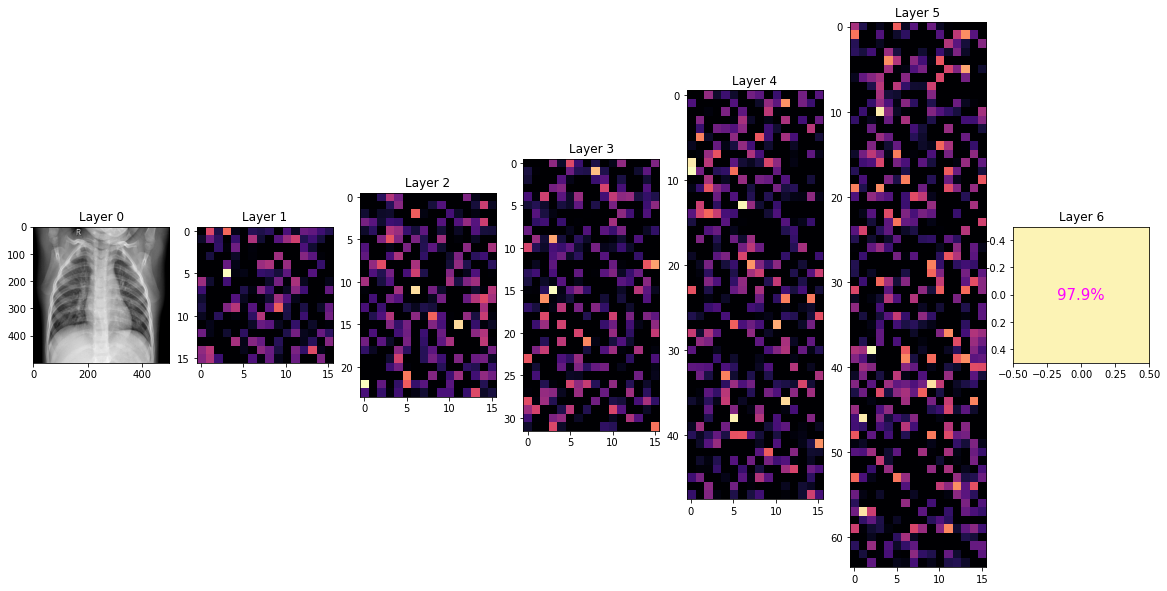

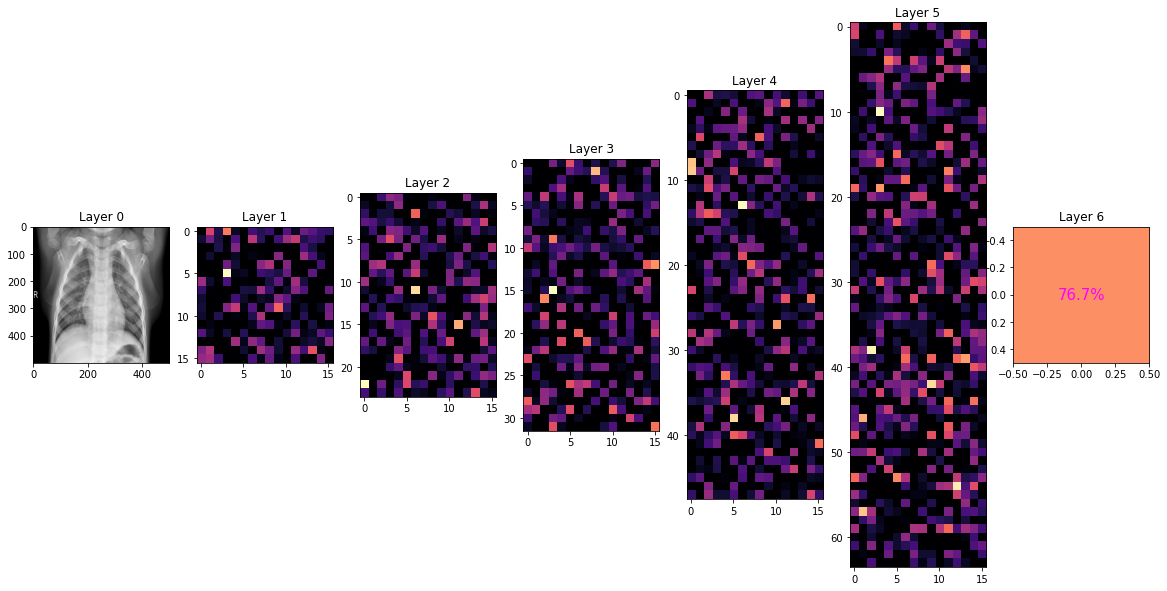

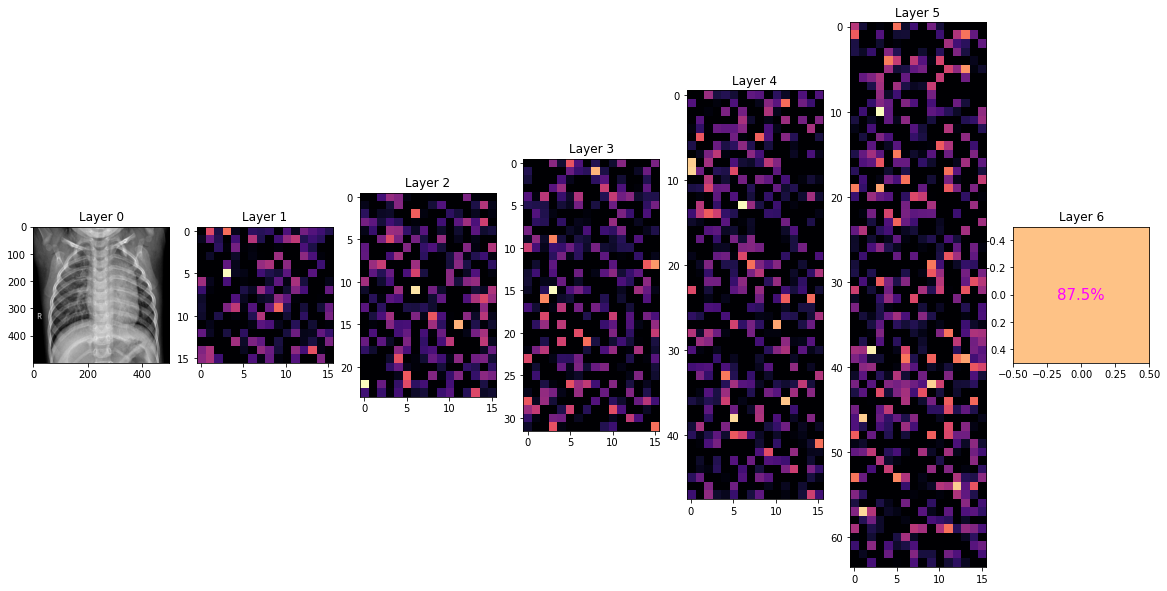

In [39]:
reshape_mapping={0: (500, 500), 
                 1 : (16, 16), 
                 2 : (24, 16), 
                 3 : (32, 16), 
                 4 : (48, 16), 
                 5 : (64, 16), 
                 6 : (1,1)}

plot_network_activations(network, indices_to_plot=[0, 1, 14, 8, 9, 10], reshape_mapping=reshape_mapping)


### Plot the weights

Just as we did with activations above, let's plot the weights and see if we can get a feel of the transformations that are applied to an image as it flows forward from the input layer to the first hidden layer.

In the first hidden layer, there are a group of weights that connects an input image (the input layer) each unit in the layer. There are 256 units in the first hidden layer, so there are 256 such groups of weights. In each group, there are 250,000 weights, with each value corresponding to the weight of a specific pixel location.

The shape of the weight matrix for the first hidden layer is `(256, 250000)`, and each row of this matrix is the group of weights that connects an input image (the input layer) to a given unit in the first hidden layer.

Let's plot the first 16 out of the 256 in a 4 by 4 grid of subplots.

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


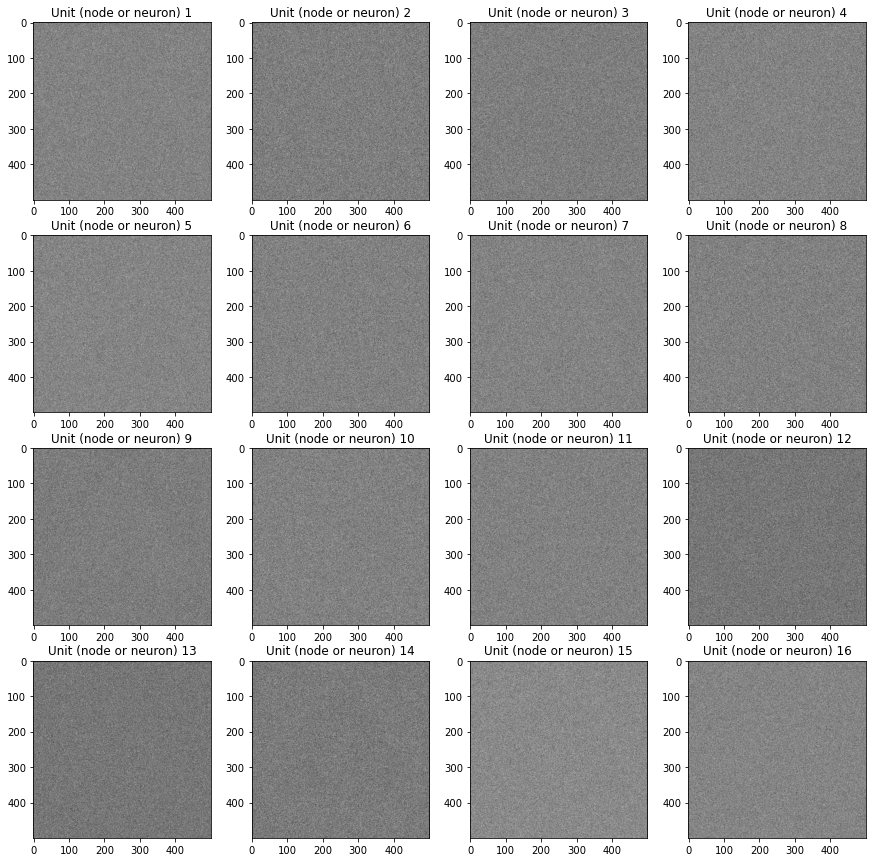

In [40]:
    
fig, axes = pyplot.subplots(4, 4, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    weights=network.layers[1].W[i,:]
    weights_norm=(weights-weights.min())/(weights.max()-weights.min())
    ax.imshow(weights_norm.reshape(500, 500), cmap="gray")
    ax.set_title("Unit (node or neuron) {}".format(i+1))

fig.show()

Ha! There is nothing recognizable to the human eye here. However, each unit in the first hidden layer is generated from the dot product of the plotted weight and an input image. Each one of these 256 groups of weights learn patterns that ultimately helps the network to distinguish between x-ray images of pneumonia vs normal. If this was a convolutional neural net, you would actually see these patterns in the plots.

### Average activation patterns

Another interesting thing to look at is which units (nodes) tended to fire for pneumonia vs for normal. How similar or dissimilar are the patterns.

To do this, we will isolate all the examples (records) that were *strongly* predicted as pneumonia (i.e. output activation < 0.05) or as normal (i.e. output activation > 0.95) and then average across all those examples.

The function `average_activations_for_each_class` selects examples that are *strongly* and *correctly* predicted for each class and then averages these activations across all the examples in the batch. 

The function `combine_average_activations` takes two dicts of activations and computes the average activations for both. It averages the average activations calculated for each batch in order to get the average activations for strongly and correctly predicted examples across the entire training set.


In [41]:
def average_activations_for_each_class(network):
    
    L=len(network.layers)-1 # output layer serial number
    
    # Get indices for all correctly and strongly predicted examples. 
    cls_pneum_indices=np.where((network.Y_batch == 0) & (network.Y_batch == network.Y_pred) & (network.layers[L].A <0.05))
    cls_normal_indices=np.where((network.Y_batch == 1) & (network.Y_batch == network.Y_pred) & (network.layers[L].A >0.95))
    
    # Extract only the column indices.
    cls_pneum_col_indices = cls_pneum_indices[1]
    cls_normal_col_indices = cls_normal_indices[1]
    
    # Calculate the average for each class.
    avg_activs_pneum=dict()
    avg_activs_normal=dict()
    for l in range(0,len(network.layers)):
        avg_activs_pneum[l]=network.layers[l].A[:, cls_pneum_col_indices].mean(axis=1, keepdims=True)
        avg_activs_normal[l]=network.layers[l].A[:, cls_normal_col_indices].mean(axis=1, keepdims=True)
    
    return avg_activs_pneum, avg_activs_normal

def combine_average_activations(avg_activs1, avg_activs2):
    assert len(avg_activs1)==len(avg_activs2)

    new_avg_activs=dict()
    
    for l in avg_activs1.keys():
        new_avg_activs[l]=(avg_activs1[l]+avg_activs2[l])/2
        
    return new_avg_activs

In [42]:
# Average the activations (in every layer) for all the strongly and correctly predicted examples for each class.

batch_size=150
num_epochs=1


final_avg_activs_pneum=dict()
final_avg_activs_normal = dict()

# Initialize both dicts of numpy arrays with zeros.
for l in range(0,len(network.layers)):
    final_avg_activs_normal[l] = final_avg_activs_pneum[l] = np.zeros((network.layers[l].num_units,1))

for batch in data_train.batch(batch_size, drop_remainder=True).repeat(num_epochs).as_numpy_iterator():
        
    network.X=batch[0].T
    network.Y=batch[1].T
    network._network_forward_prop()
    
    avg_activs_pneum_batch, avg_activs_normal_batch = average_activations_for_each_class(network)
    final_avg_activs_pneum = combine_average_activations(final_avg_activs_pneum, avg_activs_pneum_batch)
    final_avg_activs_normal = combine_average_activations(final_avg_activs_normal, avg_activs_normal_batch)

In [43]:
def plot_dict_activations(dict_of_activations, reshape_mapping, layers_to_exclude, title=None):
    
    if title==None: title=""
    
    num_plots = len(dict_of_activations)-len(layers_to_exclude)
    
    fig, axes = pyplot.subplots(1, num_plots , figsize=(20, 10))

    # ensure the subplots (axes) are in a list if not already so. 
    if isinstance(axes, np.ndarray): 
        axes = axes.flat
    else:
        axes=[axes]

    i=0
    for l in dict_of_activations.keys():
        
        if l in layers_to_exclude:
            continue
            
        activations=dict_of_activations[l].reshape(reshape_mapping[l])

        if l < (len(network.layers)-1):
            # For hidden layers and input layer.
            
            axes[i].imshow(activations, cmap="magma")
        else: 
            # For the output layer. 

            # set the range of the colormap to: 0 to 1.
            axes[i].imshow(activations, cmap="magma", vmin=0, vmax=1)
            axes[i].text(0,0, str((100*activations.squeeze()).round(1))+"%", fontsize=25,
                         ha='center',va='center', color="magenta")

        axes[i].set_title("Layer {}".format(l))
        
        i+=1 # subplot index (i) that corresponds to layer serial number (l).
        
    fig.suptitle(title, fontsize=20)
    fig.show()

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


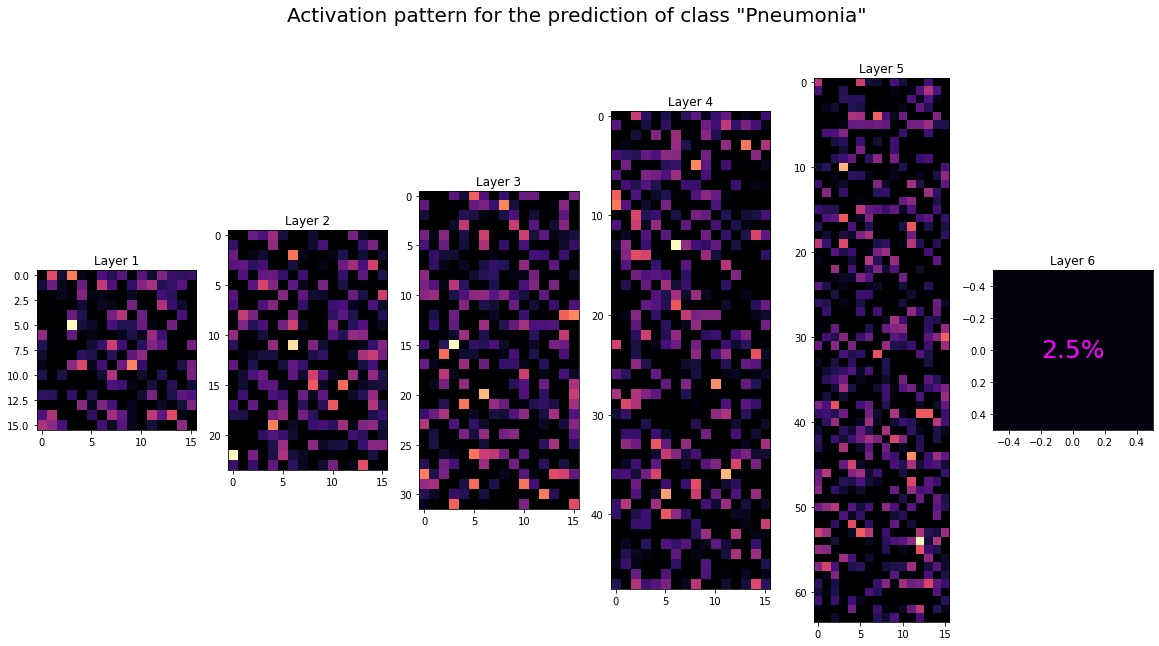

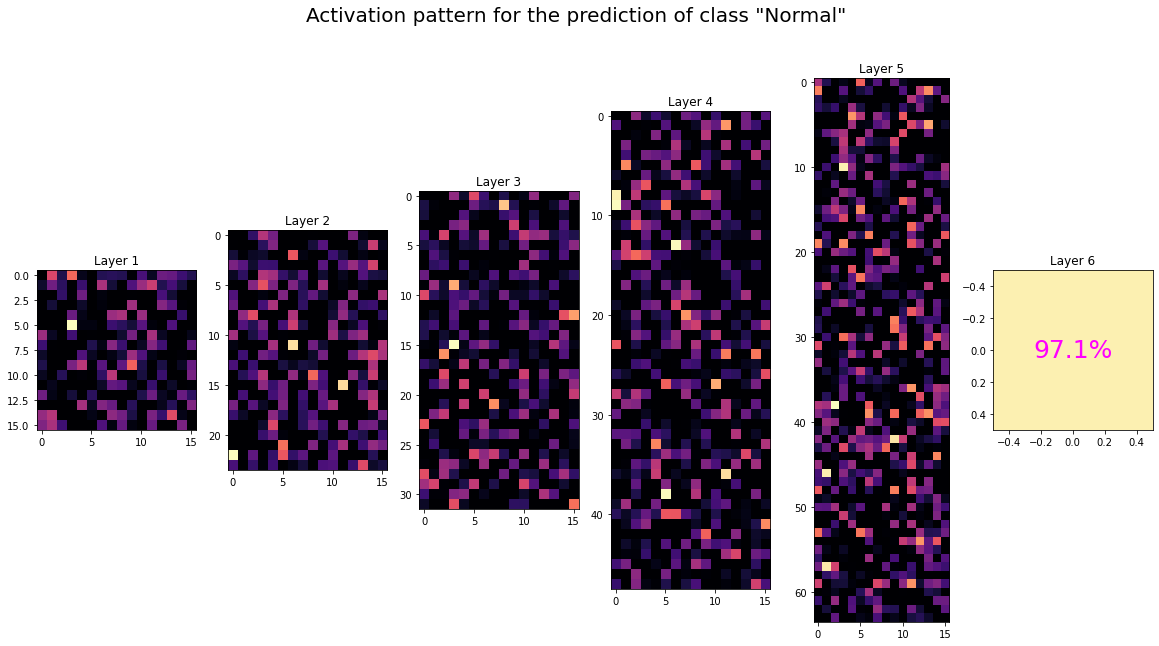

In [44]:
reshape_mapping={0: (500, 500), 
                 1 : (16, 16), 
                 2 : (24, 16), 
                 3 : (32, 16), 
                 4 : (48, 16), 
                 5 : (64, 16), 
                 6 : (1,1)}


# reshape_mapping={0: (500, 500), 
#                  1 : (16, 16), 
#                  2 : (32, 16), 
#                  3 : (64, 16), 
#                  4 : (1, 1)}

title_pneum='Activation pattern for the prediction of class "Pneumonia"'
title_normal='Activation pattern for the prediction of class "Normal"'
plot_dict_activations(final_avg_activs_pneum, reshape_mapping, layers_to_exclude = [0], title=title_pneum)
plot_dict_activations(final_avg_activs_normal, reshape_mapping, layers_to_exclude = [0], title=title_normal)

## Closing remarks

The MLP architecture is less suitable for images, and the biggest step for improvement would frankly be to swap in an architecture better suited for images, e.g. convolutional neural nets. 

However, there are many other things that can also be done to improve this network and its optimization. The parameter updating is done exclusively via standard stochastic gradient descent (mini-batch). This is were adaptive updating schemes, like [Adam](https://arxiv.org/abs/1412.6980), [Adagrad](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf), etc., could prove beneficial.

Also, there was no regularization of the cost function, nor normalization of the preactivations or activations of the hidden layers, nor any data augmentation of the images. Moreover, we didn't use every single image in the dataset because we undersampled one class in order to obtain a perfectly balanced dataset. And we had to do this because the code implementation of the cost function did not give room for class weights, which can be used to counteract the adverse effect of class imbalance. All of these leave room for improvement. 

In fact, there are a host of other things that can be done to improve the machine learning for this task. To put things in context, neural nets started [surpassing human-level perfomance](https://arxiv.org/abs/1502.01852) on image classification about 5 years ago. Typically, results lower than 90% accuracy for image classification are not impressive. You want to be shooting for above 97%. However, this is not a hard and fast rule. For instance, the researchers that produced this dataset <a href="https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5">only reached 93% accuracy</a> with the machine learning techniques they used, even though they achieved 97% on their other dataset of optical coherence tomography images.